In [1]:
%matplotlib notebook
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as  pd
import numpy as np
import sys
import io
import os


In [2]:
PSK_ERROR_MISSING_RX = 10.0

def haversine_distance(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points
    on the earth (specified in decimal degrees)
    
    All args must be of equal length.    
    
    """
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])
    
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    
    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2
    
    c = 2 * np.arcsin(np.sqrt(a))
    km = 6378.137 * c
    return km * 1000

def haversine_bearing(lon1, lat1, lon2, lat2):
    """
    Calculate the initial bearing on the great circle starting at (lon1, lat1)
    and ending at (lon2, lat2)
    
    https://www.movable-type.co.uk/scripts/latlong.html
    """
    
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])
    # const y = Math.sin(λ2-λ1) * Math.cos(φ2);
    y = np.sin(lon2 - lon1) * np.cos(lat2)
    
    # const x = Math.cos(φ1)*Math.sin(φ2) -
    #       Math.sin(φ1)*Math.cos(φ2)*Math.cos(λ2-λ1);
    x = np.cos(lat1) * np.sin(lat2) - np.sin(lat1) * np.cos(lat2) * np.cos(lon2-lon1)
    
    # const θ = Math.atan2(y, x);
    theta = np.arctan2(y, x)

    # const brng = (θ*180/Math.PI + 360) % 360; // in degrees
    return np.mod(theta * 180 / np.pi + 360, 360)
    

def generate_dataset(cruise_id, dive_id, **kwargs):
    """
    Generate a pandas DataFrame
    """
    
    # Directories we'll be using within the overall cruise structure
    doc_root = f"{cruise_id}/docs"
    dive_root = f"{cruise_id}/dives/{dive_id}"
    navest_root = f"{dive_root}/nav-sci/raw/topside-nav"
    topside_umodem_root = kwargs.get("topside_umodem_root", f"{dive_root}/topside-comms/acomm-top")
    nav_sci_root = f"{dive_root}/nav-sci"
    
    # Parse launch and recovery times from docs file
    cmd = f"grep launch {doc_root}/{dive_id}_event_summary.tex | cut -d' ' -f1,2"
    output = ! {cmd}
    timestamp_launch = pd.to_datetime(output[0])

    cmd = f"grep recovery {doc_root}/{dive_id}_event_summary.tex | cut -d' ' -f1,2"
    output = ! {cmd}
    timestamp_recovery = pd.to_datetime(output[0])

    # Topside micromodem CACST records
    # THe CACST record (Communication RX Statistics) is generated each time we hear a
    # micromodem message, even if it fails to be properly demodulated.  We'll use this
    # as the basis for our dataset
    cmd = f"grep -hr SDE {topside_umodem_root}/*ACM | grep \$CACST | sed 's/[,\*]/ /g' | cut -d' ' -f2,3,6-"
    extracted = ! {cmd}
    df = pd.read_csv(io.StringIO('\n'.join(extracted)), sep=' ', header=None, index_col="t",
                        names=["date", "time", "id", "version", "mode", "toa_time", "toa_mode", "mfd_peak",
                              "mfd_power", "mfd_ratio", "spl", "shf_agn", "shf_ainpshift", "shf_ainshift", 
                              "shf_mfdshift", "shf_p2bshift", "rate", "src", "dest", "psk_error", "packet_type",
                              "nframes", "nbad", "snr_rss", "snr_in", "snr_out", "snr_symbols", "mse", 
                              "dqf", "dop", "noise_stdev", "carrier_hz", "bandwidth_hz", "pcm"],
                        parse_dates=dict(t=["date", "time"]), date_format="%Y/%m/%d %H:%M:%S.%f").sort_index()
   
    if df.empty:
        import warnings
        warnings.warn(f"no $CACST messages in {topside_umodem_root}")
        return
 
    # only keep data between launch and recovery
    df = df[(df.index >= timestamp_launch) & (df.index <= timestamp_recovery)]

    # We expect to receive a packet from Sentry every minute.  Here we find gaps where we receive nothing topside
    # and insert empty records with a custom 'psk_error' value for our analysis
    # We'll use 65 seconds to give us a little padding
    missing = df.index.to_series().diff() > np.timedelta64(65, 's')

    global PSK_ERROR_MISSING_RX

    for ts in df.index[missing]:
        iloc = df.index.get_loc(ts)
        prev_ts = df.index[iloc-1]
        gap = ts - prev_ts
        missing_ts = prev_ts + np.timedelta64(1, 'm')
        n_inserted = 0
        while missing_ts <= ts - np.timedelta64(5, 's'):
            df.at[missing_ts, 'psk_error'] = PSK_ERROR_MISSING_RX
            missing_ts += np.timedelta64(1, 'm')
            n_inserted += 1

    df.sort_index(inplace=True)    

    # Ship GPS from raw navest logs
    cmd = f"grep ^SHIPGPS {navest_root}/*DAT | grep \$GPGGA | cut -d' ' -f2,7 | sed \"s/,/ /g\" | cut -d' ' -f1,3,4-7 | head -n-1"
    extracted = ! {cmd}
    ship_gps = pd.read_csv(io.StringIO('\n'.join(extracted)), sep=' ', header=None, index_col="t",
                       names=['date', 'time', 'raw_lat', 'lat_dir', 'raw_lon', 'lon_dir'],
                       dtype=dict(raw_lat='float', raw_lon='float'),
                       parse_dates={'t': [0, 1]}, date_format="%Y/%m/%d %H%M%S.%f").sort_index()

    #deduplicate - sometimes we receive the same GGA mulitple times
    ship_gps = ship_gps[~ship_gps.index.duplicated(keep='first')]

    #only keep data between launch and recovery
    ship_gps = ship_gps[(ship_gps.index >= timestamp_launch) & (ship_gps.index <= timestamp_recovery)]

    ship_gps['lat'] = ((ship_gps['raw_lat'] / 100).astype(int) + ship_gps['raw_lat'].mod(100) / 60)
    ship_gps['lon'] = (ship_gps['raw_lon'] / 100).astype(int) + ship_gps['raw_lon'].mod(100) / 60
    
    ship_gps.loc[ship_gps['lat_dir'] == 'S', "lat"] *= -1
    ship_gps.loc[ship_gps['lon_dir'] == 'W', "lon"] *= -1
    
    # Add ship lat/lon to our dataset, interpolated to our time index
    df['lon_ship'] = np.interp(df.index, ship_gps.index, ship_gps['lon'])
    df['lat_ship'] = np.interp(df.index, ship_gps.index, ship_gps['lat'])
    
    # Ship heading from raw navest logs
    cmd = f"grep ^SHIPGPS {navest_root}/*DAT | grep \$HEHDT | cut -d' ' -f2,3,7 | sed \"s/,/ /g\" | cut -d' ' -f1,2,4 | head -n-1"
    extracted = ! {cmd}
    ship_heading = pd.read_csv(io.StringIO('\n'.join(extracted)), sep=' ', header=None, index_col="t",
                       names=['raw_date', 'raw_time', 'heading'],
                       dtype=dict(heading='float'),
                       parse_dates={'t': [0, 1]}, date_format="%Y/%m/%d %H:%M:%S.%f").sort_index()

    #deduplicate - sometimes we receive the same GGA mulitple times
    ship_heading = ship_heading[~ship_heading.index.duplicated(keep='first')]
    
    # Add ship heading to our dataset
    df['heading_ship'] = np.interp(df.index, ship_heading.index, ship_heading['heading'])
    
    # Get sentry nav fromt the SCC file - it's good enough for our needs here
    scc_file =  ! ls {nav_sci_root}/proc/{dive_id}_????????_????.scc
    sentry = pd.read_csv(scc_file[-1], sep=' ', skiprows=[0, 1], header=None, index_col="t",
                 usecols=[1, 2, 3, 4, 5, 6, 7],
                 names=['date', 'time', 'lat', 'lon', 'depth', 'heading', 'alt'],
                 parse_dates=dict(t=[0, 1]), date_format="%Y/%m/%d %H:%M:%S.%f")
    
    # Add vehicle data to our dataset
    for col in sentry.columns:
        df[f"{col}_sentry"] = np.interp(df.index, sentry.index, sentry[col])
       
    # Calculate the horizontal range between ship and sentry using the haversine formula
    df["range_horizontal"] = haversine_distance(df["lon_ship"], df["lat_ship"], df["lon_sentry"], df["lat_sentry"])
    
    # Calculate the full sant range using sentry's depth
    df["range_slant"] = np.sqrt(np.power(df["range_horizontal"], 2) + np.power(df["depth_sentry"], 2))
    
    # Calculate the nadir look angle
    df['nadir_angle'] = np.arcsin(df.range_horizontal/df.range_slant) * 180 / np.pi
    
    # Calculate the absolute bearing from ship to sentry
    df["absolute_bearing"] = haversine_bearing(df["lon_ship"], df["lat_ship"], df["lon_sentry"], df["lat_sentry"])
    
    # Calculate the bearing relative to ship-forward from ship to sentry
    df["relative_bearing"] = np.mod(df['absolute_bearing'] - df["heading_ship"], 360)
    
    # Insert cruise and dive ID's into dataset
    df.insert(0, "dive", dive_id)
    df.insert(0, "cruise", cruise_id)
    
    # Write out the csv
    df.to_csv(f"{dive_id}_cacst.csv", mode="w")

In [3]:
DIVES = {
    "AT50-26": [dict(dive_id=d) for d in ["sentry731", "sentry732", "sentry733"]],
    #"2022-nooner": [dict(dive_id=f"sentry{d}") for d in range(648, 655)],
    #"2020-chadwick": [dict(dive_id=f"sentry{d}", 
    #                       topside_umodem_root=f"2020-chadwick/dives/sentry{d}/topside-comms/acomm") for d in range(564, 569)]
}

for cruise_id in DIVES:
    for kwds in DIVES[cruise_id]:
        dive_id = kwds["dive_id"]
        if not os.path.isfile(f"{dive_id}_cacst.csv"):
            generate_dataset(cruise_id, **kwds)

In [4]:
files = !ls sentry???_cacst.csv
df = pd.concat(filter(lambda df_: not df_.empty, [pd.read_csv(f, index_col="t") for f in files])).sort_index()

# Setup the rx category
df['rx'] = "Ok"                                 #  OK: We were able to receive the message
df.loc[df.psk_error != 0.0, 'rx'] = "Error"     #  Error: Heard the message but could not process it
                                                #         (bad CRD, low SNR, etc.)
df.loc[df.psk_error == 10.0, 'rx'] = "Missing"  #  Missing:  Completely missed the message

First thing we can compare is the number of received messages from Sentry; how many were correctly decoded, how many failed decoding, and how many were missed entirely.  It is not unusual to miss a large number of messages entirely for these dives as Sentry spends a good chunk of time very far from the ship.

<IPython.core.display.Javascript object>


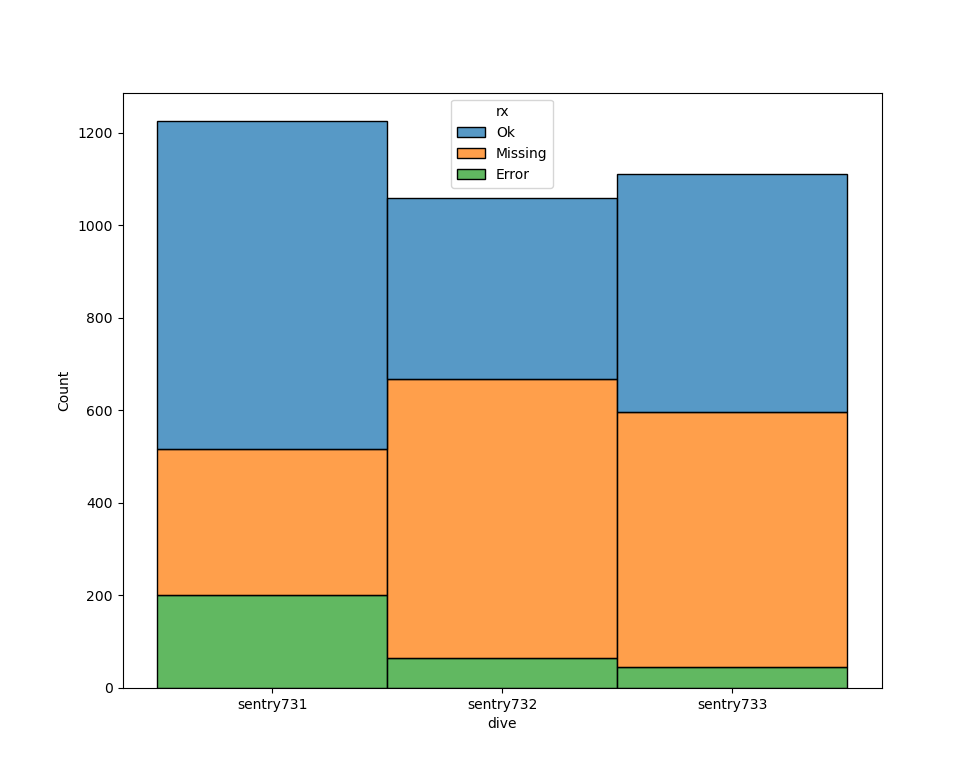

<Axes: xlabel='dive', ylabel='Count'>

In [5]:
sns.histplot(df, x='dive', hue='rx', multiple='stack')

During AT50-26 it seemed that acoustic performance was worse when Sentry was off the starboard side of Atlantis.  If we group the above statistics by relative bearing instead of dive number we can see some evidence of this in the number of missing packets.  However, this graph doesn't take into account whether we *expect* the packet to be missing (for example, if Sentry was more than 10km away it doesn't really matter how good or bad the ship-side acoustics are, we wouldn't expect to receive the data).

<IPython.core.display.Javascript object>


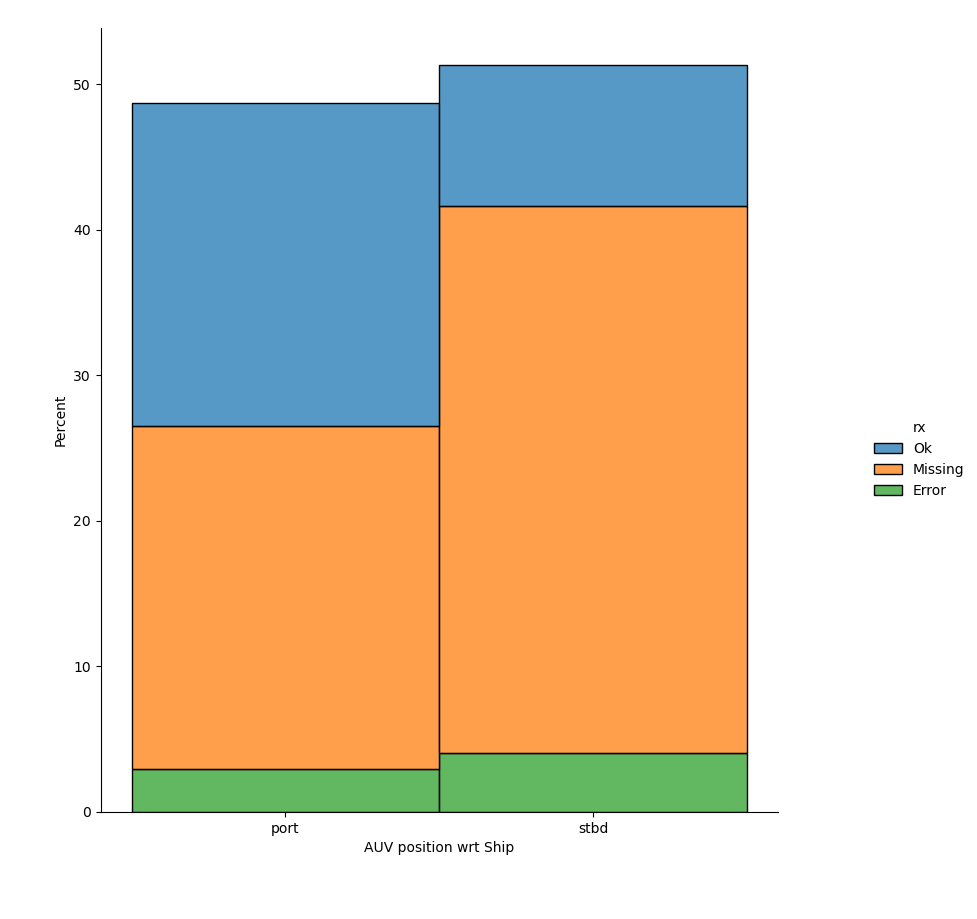

In [6]:
index = df.nadir_angle >= 60.0
side = pd.Series(data="port", index=df.index)
side.loc[df.relative_bearing < 180] = "stbd"
side.name = "AUV position wrt Ship"
sns.displot(df[index], kind='hist', hue="rx",
            x=side[index], multiple="stack", stat="percent")

In general we expect to have good communication with Sentry when our horizontal distance to the AUV is "within one water-depth".  At Axial the depth is approximately 1500m, so whenever we're within 1500m horizontal distance from the AUV we'd expect a good communication link. In practice we observe good performance a distances much larger than one water depth with the micromodem.

The "nadir angle" is the angle formed between Sentry, the ship, and the vertical axis (downward).  Nadir angles less than 45 degrees correspond to horizontal separations between the ship and Sentry within the "one water-depth" rule.  We can further look for trends in how each category of reception ("Ok", "Error", and "Missing") varies with the nadir angle and see if there's any difference between port and starboard.

The first plot below shows all nadir angles.  The second plot shows only statistics for which the nadir angle is greather than 60, more than one water depth.

<IPython.core.display.Javascript object>


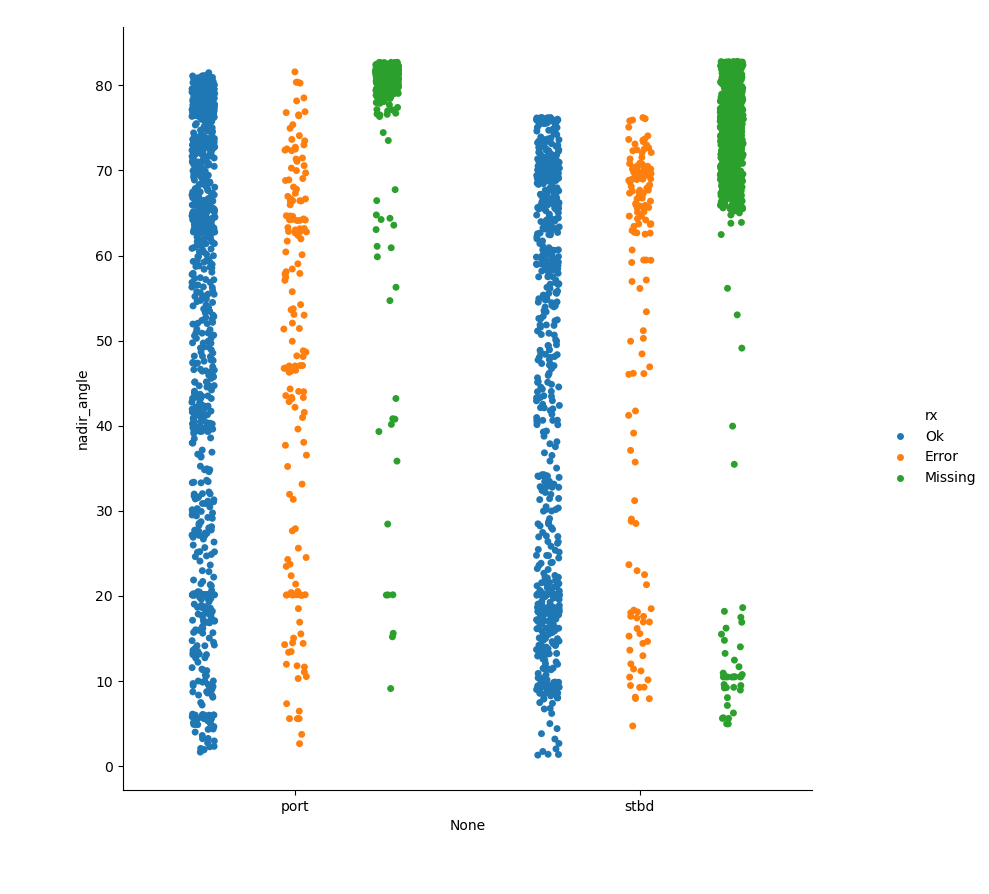

<IPython.core.display.Javascript object>


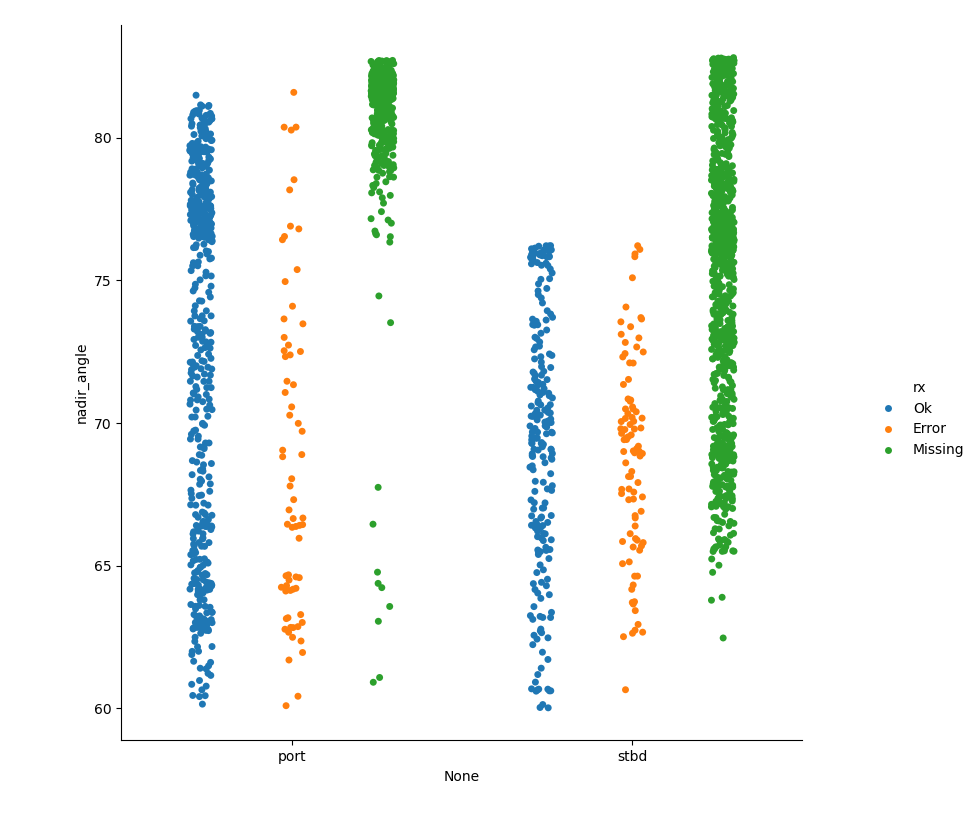

In [7]:
index = df.nadir_angle >= 0
side = pd.Series(data="port", index=df.index)
side.loc[df.relative_bearing < 180] = "stbd"

sns.catplot(df[index], kind='strip', hue="rx", hue_order=["Ok", "Error", "Missing"],
            x=side[index], y="nadir_angle", dodge=True)

index = df.nadir_angle >= 60
sns.catplot(df[index], kind='strip', hue="rx", hue_order=["Ok", "Error", "Missing"],
            x=side[index], y="nadir_angle", dodge=True)

Some ovservations from these two plots seem to cooborate the anectdotal eveidenc that acoustic performance is worse off the starboard side:

1. We miss entirely **way** more messages on the starboard side.  We stop hearing at around a nadir angle of 65, compared to about 75 for the port side.
2. There's an apparent hard-limit to reception good or bad of about 75 degrees on the starboard side, whereas we can receive and decode messages on the port side up to about 80 degrees.

Point #2 could be explained by transducer placement on the hull and physical shadowing, but I'm not sure that would also explain #1

The plot below shows the relative bearing and nadir angle for all messages received (or not) with nadir angles greather than 45 degrees for the three dives.  This shows relatively similar amounts of messages the port and starboard sides

<IPython.core.display.Javascript object>


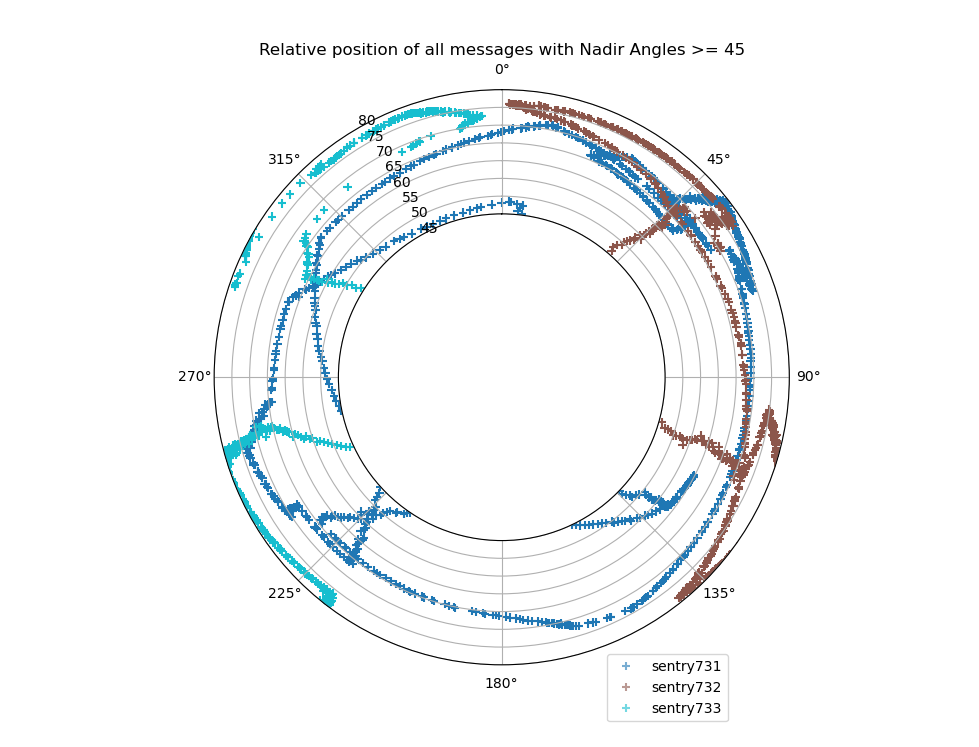

In [8]:
dive_categories = df.dive.astype('category')
colors = dive_categories.cat.codes
theta = df.relative_bearing * np.pi / 180
fig, ax = plt.subplots(subplot_kw=dict(projection="polar"))

index = (df.nadir_angle > 45)
scatter = ax.scatter(theta[index], df[index].nadir_angle[index], marker='+', c=colors[index], cmap="tab10")
ax.set_theta_zero_location('N')
ax.set_theta_direction(-1)
ax.set_title("Relative position of all messages with Nadir Angles >= 45")

#ax.set_rmax(8000)
ax.set_rmin(45)
ax.set_rmax(80)
ax.set_rorigin(-1.0)
ax.set_rlabel_position(330)

handles, _ = scatter.legend_elements(prop="colors", alpha=0.6) # use my own labels
angle = np.deg2rad(290)
ax.legend(handles, dive_categories.cat.categories, loc="upper left", bbox_to_anchor=(.5 + np.cos(angle)/2, .5 + np.sin(angle)/2))
plt.show()

But if we only plot the messages that failed to decode or were missed entirely we see the number is much larger on the starboard side than the port side

<IPython.core.display.Javascript object>


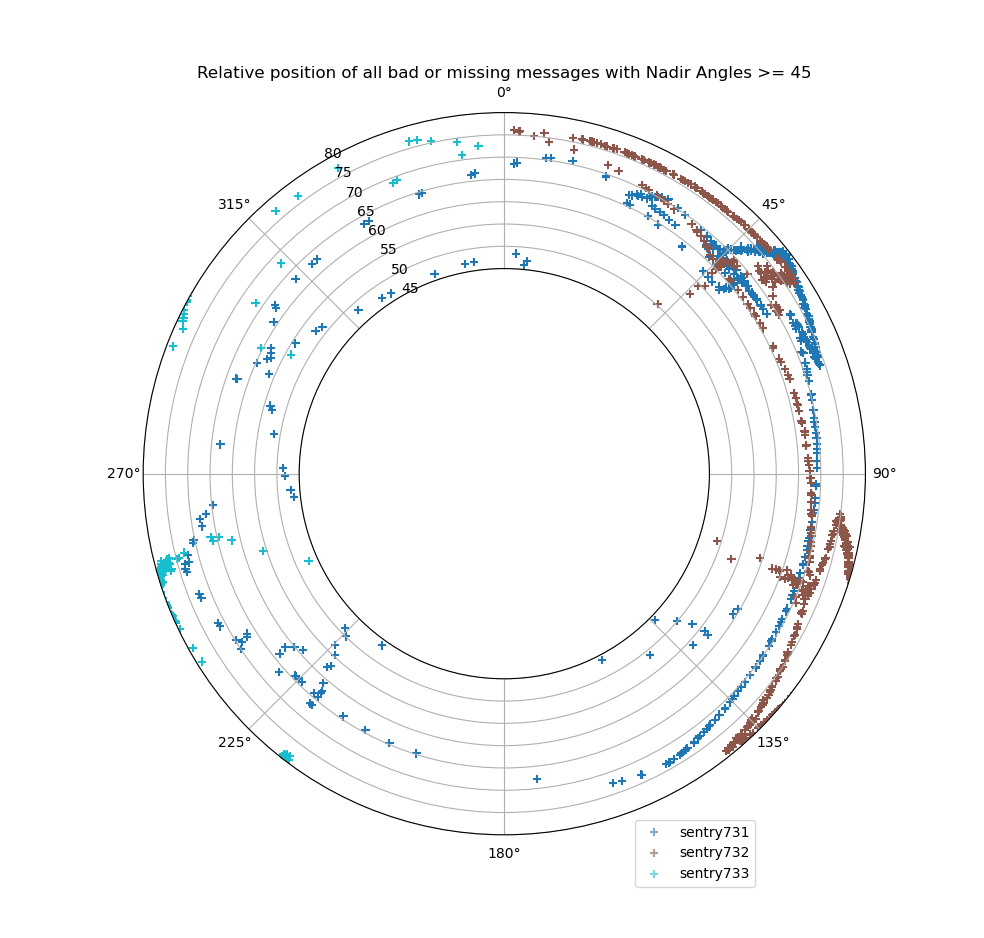

In [9]:
dive_categories = df.dive.astype('category')
colors = dive_categories.cat.codes
theta = df.relative_bearing * np.pi / 180
fig, ax = plt.subplots(subplot_kw=dict(projection="polar"))

index = (df.nadir_angle > 45) & (df.rx != "Ok")
scatter = ax.scatter(theta[index], df[index].nadir_angle[index], marker='+', c=colors[index], cmap="tab10")
ax.set_theta_zero_location('N')
ax.set_theta_direction(-1)
ax.set_title("Relative position of all bad or missing messages with Nadir Angles >= 45")

#ax.set_rmax(8000)
ax.set_rmin(45)
ax.set_rmax(80)
ax.set_rorigin(-1.0)
ax.set_rlabel_position(330)

handles, _ = scatter.legend_elements(prop="colors", alpha=0.6) # use my own labels
angle = np.deg2rad(290)
ax.legend(handles, dive_categories.cat.categories, loc="upper left", bbox_to_anchor=(.5 + np.cos(angle)/2, .5 + np.sin(angle)/2))
plt.show()

And similarly there's more no the port side when when only good messages are plotted

<IPython.core.display.Javascript object>


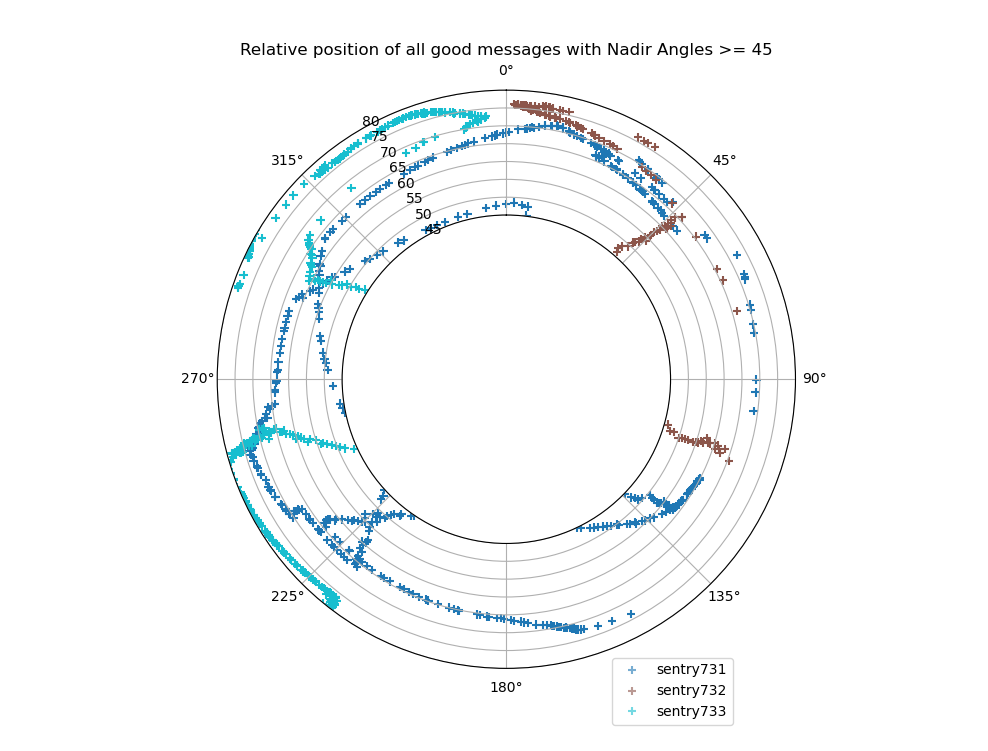

In [10]:
dive_categories = df.dive.astype('category')
colors = dive_categories.cat.codes
theta = df.relative_bearing * np.pi / 180
fig, ax = plt.subplots(subplot_kw=dict(projection="polar"))

index = (df.nadir_angle > 45) & (df.rx == "Ok")
scatter = ax.scatter(theta[index], df[index].nadir_angle[index], marker='+', c=colors[index], cmap="tab10")
ax.set_theta_zero_location('N')
ax.set_theta_direction(-1)
ax.set_title("Relative position of all good messages with Nadir Angles >= 45")

#ax.set_rmax(8000)
ax.set_rmin(45)
ax.set_rmax(80)
ax.set_rorigin(-1.0)
ax.set_rlabel_position(330)

handles, _ = scatter.legend_elements(prop="colors", alpha=0.6) # use my own labels
angle = np.deg2rad(290)
ax.legend(handles, dive_categories.cat.categories, loc="upper left", bbox_to_anchor=(.5 + np.cos(angle)/2, .5 + np.sin(angle)/2))
plt.show()